<a href="https://colab.research.google.com/github/kundajelab/feature_interactions/blob/master/zeropadding/TrainModels_AnscombeMSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#download raw data
!wget https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_simulation.simdata.gz
!wget https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_neg_labels.txt.gz
!wget https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_pos_labels.txt.gz

--2020-06-25 16:53:40--  https://github.com/kundajelab/feature_interactions/raw/2349aab/zeropadding/data/train_simulation.simdata.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/feature_interactions/2349aab4a9eea5e20861123641d84f04cfb8f853/zeropadding/data/train_simulation.simdata.gz [following]
--2020-06-25 16:53:41--  https://raw.githubusercontent.com/kundajelab/feature_interactions/2349aab4a9eea5e20861123641d84f04cfb8f853/zeropadding/data/train_simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2104123 (2.0M) [application/octet-stream]
Saving to: ‘train_simulation.

In [3]:
!gunzip *.gz

In [14]:
!md5sum *

md5sum: colab_notebook_data: Is a directory
md5sum: drive: Is a directory
md5sum: sample_data: Is a directory
4b333f203544ecb389fdf8114297d874  train_neg_labels.txt
306bf8d95f49454c117e664d3dc61030  train_pos_labels.txt
fb82dd3c7dc4b53d34b4fd456394de42  train_simulation.simdata


In [5]:
!pip install simdna

     |████████████████████████████████| 634kB 2.7MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done


In [6]:
import simdna
from simdna import synthetic

In [7]:
train_data = synthetic.read_simdata_file("train_simulation.simdata")

In [8]:
import numpy as np


#this is set up for 1d convolutions where examples
#have dimensions (len, num_channels) 
#the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def anscombe_transform(vals):
  return 2*np.sqrt(vals + 3.0/8)


def inverse_anscombe_transform(vals):
  return np.square(vals/2.0) - 3.0/8


def read_labels_and_oracle(filename):
  labels = anscombe_transform(np.array([float(x.split("\t")[0]) for
                                          x in open(filename)]))
  oracle = anscombe_transform(np.array([float(x.split("\t")[1]) for
                                          x in open(filename)]))
  return labels, oracle


train_onehot_data = np.array([one_hot_encode_along_channel_axis(seq)
                              for seq in train_data.sequences])

train_pos_labels, train_pos_oracle =\
  read_labels_and_oracle("train_pos_labels.txt")
train_neg_labels, train_neg_oracle =\
  read_labels_and_oracle("train_neg_labels.txt")

Train models

In [9]:
#define model architectures

import keras
import string
import random


def model_arch1(l1_reg):
  model = keras.models.Sequential()
  for i in range(4):
    added_kwarg = {}
    if (i==0):
      added_kwarg["input_shape"] = (100,4)
    model.add(keras.layers.Conv1D(
                filters=15, kernel_size=7, 
                activation = "relu",
                kernel_initializer="he_normal",
                kernel_regularizer=keras.regularizers.l1(l1_reg),
                **added_kwarg))
  model.add(keras.layers.GlobalAveragePooling1D()) 
  for i in range(2):
    model.add(keras.layers.Dense(50, activation="relu",
              kernel_initializer="he_normal",
              kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.add(keras.layers.Dense(1, activation="linear"))
  adam = keras.optimizers.Adam()
  model.compile(optimizer=adam, loss="mean_squared_error")
  return model


def model_arch2(l1_reg):
  model = keras.models.Sequential()
  for i in range(4):
    added_kwarg = {}
    if (i==0):
      added_kwarg["input_shape"] = (100,4)
    model.add(keras.layers.Conv1D(
                filters=15, kernel_size=7, 
                activation = "relu",
                kernel_initializer="he_normal",
                kernel_regularizer=keras.regularizers.l1(l1_reg),
                **added_kwarg))
  model.add(keras.layers.GlobalAveragePooling1D()) 
  for i in range(3):
    model.add(keras.layers.Dense(30, activation="relu",
              kernel_initializer="he_normal",
              kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.add(keras.layers.Dense(1, activation="linear"))
  adam = keras.optimizers.Adam()
  model.compile(optimizer=adam, loss="mean_squared_error")
  return model


def model_arch3(l1_reg):
  model = keras.models.Sequential()
  for i in range(5):
    added_kwarg = {}
    if (i==0):
      added_kwarg["input_shape"] = (100,4)
    model.add(keras.layers.Conv1D(
                filters=15, kernel_size=5, 
                activation = "relu",
                kernel_initializer="he_normal",
                kernel_regularizer=keras.regularizers.l1(l1_reg),
                **added_kwarg))
  model.add(keras.layers.GlobalAveragePooling1D()) 
  for i in range(3):
    model.add(keras.layers.Dense(30, activation="relu",
              kernel_initializer="he_normal",
              kernel_regularizer=keras.regularizers.l1(l1_reg)))
  model.add(keras.layers.Dense(1, activation="linear"))
  adam = keras.optimizers.Adam()
  model.compile(optimizer=adam, loss="mean_squared_error")
  return model


def train_and_save_model(model_constructor, prefix, X_train, y_train,
                         X_valid, y_valid, seed):
  
  barcode = ''.join(random.choice(string.ascii_lowercase) for i in range(5))
  np.random.seed(seed)
  model = model_constructor()
  save_filename = prefix+"_"+barcode+".h5"
  print("Training model", save_filename)
  print(model.summary())
  model.fit(x=X_train, y=y_train, batch_size=200,
            epochs=1000,
            validation_data=(X_valid, y_valid),
            callbacks=[keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=15,
                        restore_best_weights=True)])
  
  print("Save file name", save_filename)
  model.save(save_filename)
  return model


Using TensorFlow backend.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [13]:
!ln -s /content/drive/My\ Drive/colab_notebook_data/ .

ln: failed to create symbolic link './colab_notebook_data': File exists


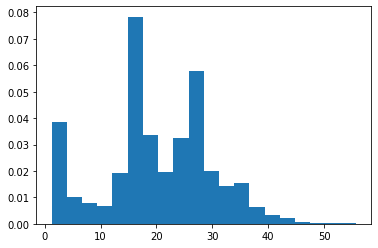

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(train_pos_labels, density=True, bins=20)
plt.show()

In [ ]:
#train the models

indices_train = np.arange(0, int(0.8 * train_onehot_data.shape[0]))
indices_valid = np.arange(int(0.8 * train_onehot_data.shape[0]),
                              train_onehot_data.shape[0])

SAVEDIR = "colab_notebook_data/feature_interactions/trained_models"

for seed in [100, 200, 300, 400, 500]:
  for l1_reg in [0.0, 0.0001, 0.001]:
    for model_constructor, archname in [(model_arch1, 'anscombemse_arch1'),
                                        (model_arch2, 'anscombemse_arch2'),
                                        (model_arch3, 'anscombemse_arch3')]:
        """train_and_save_model(
            model_constructor=lambda: model_constructor(l1_reg),
            prefix=(SAVEDIR+"/poscontrol_model-"+archname
                    +"_l1reg-"+str(l1_reg)+"_seed"+str(seed)),
            X_train=train_onehot_data[indices_train],
            y_train=train_pos_labels[indices_train],
            X_valid=train_onehot_data[indices_valid],
            y_valid=train_pos_labels[indices_valid],
            seed=seed) #vary the seed for initialization diversity"""
        
        train_and_save_model(
            model_constructor=lambda: model_constructor(l1_reg),
            prefix=(SAVEDIR+"/negcontrol_model-"+archname
                    +"_l1reg-"+str(l1_reg)+"_seed"+str(seed)),
            X_train=train_onehot_data[indices_train],
            y_train=train_neg_labels[indices_train],
            X_valid=train_onehot_data[indices_valid],
            y_valid=train_neg_labels[indices_valid],
            seed=seed) #vary the seed for initialization diversity


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Training model colab_notebook_data/feature_interactions/trained_models/negcontrol_model-anscombemse_arch1_l1reg-0.0_seed100_gdfnk.h5
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 94, 15)            435       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 88, 15)            1590      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 82, 15)            1590      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 76, 15)            1590      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 15)                0         
______________________________________